In [1]:
%matplotlib inline

In [2]:
from helpers_BAYC import parse_BAYCs_data, parse_sale_data, parse_listing_data

import requests
import pandas as pd
from pandas_profiling import ProfileReport
import pickle

from statistics import *
import numpy as np
from math import log

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import time
from datetime import date, timedelta, datetime

import os
import glob

#### Getting BAYCs Assets Data

The code below collects assets data about the 10,101 BAYCs. The API has a limit of 50 items per call, and therefore we need to create a loop with 204 iterations to collect all BAYCs data.

##### BAYC Data Parsed:
- 'BAYC_id'
- 'creator_username'
- 'creator_address'
- 'owner_username'
- 'owner_address'
- 'traits'
- 'num_sales'

In [3]:
def download_BAYCs_info(save_location):
    url = "https://api.opensea.io/api/v1/assets"
    listometas = []

    for i in range(0, 204):
        querystring = {"token_ids":list(range((i*50), (i*50)+50)),
                       "asset_contract_address":"0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D",
                       "order_direction":"desc",
                       "offset":"0",
                       "limit":"50"}
        response = requests.request("GET", url, params=querystring)

        print(i, end=" ")
        if response.status_code != 200:
            print('error')
            break

        # Getting BAYCs data
        BAYCs = response.json()['assets']
        # Parsing BAYCs data
        parsed_BAYCs = [parse_BAYCs_data(BAYC) for BAYC in BAYCs]
        # storing parsed BAYCs data into list
        listometas.append(parsed_BAYCs)
    
    # Flatten everything into one list
    listometas = [item for sublist in listometas for item in sublist]
    # Convert to df
    BAYCs_df = pd.DataFrame(listometas)
    
    with open(save_location + 'BAYCs_df'+str(date.today())+r'.pkl', 'wb') as f:
        pickle.dump(BAYCs_df, f)

#### Getting BAYCs sales transactions data

The code below collects all sale transactions data. 
The API has a limit of 300 items per call and 10,000 items total / response. 
Days with > 10,000 sales will require chunking (built in) but most projects aren't there yet.

##### Sales Data Parsed
- 'is_bundle'
- 'BAYC_id'
- 'seller_address'
- 'buyer_address'
- 'buyer_username'
- 'seller_username'
- 'timestamp'
- 'total_price'
- 'payment_token'
- 'usd_price'
- 'transaction_hash'

In [8]:
# Download sales info from start_date to end _date and save them all into their own day's files
# Default values to first sale ever 7/30/21 to today
def download_sales_info(save_location, start_date = date(2021, 7, 30), end_date = date.today()):
    url = "https://api.opensea.io/api/v1/events"
    # get the number of days that we want to download and save sales for
    delta = end_date - start_date
    count_days = int(delta.days)
    
    for i in range(count_days+1):
        sales_that_day = []
        # set start and end of the day we are checking, if it's today set end to current time
        if date.today() == (start_date + timedelta(days=i)):
            before = datetime.now()
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        else:
            before = datetime.combine((start_date + timedelta(days=i+1)), datetime.min.time())
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        # There are too many transactions, now have to break them up by chunks in the day
        hour_chunks = 24
        chunk_count = 24/hour_chunks
        time.sleep(.5)
        for chunk in range(int(chunk_count)):
            end = False
            for j in range(0, 100):
                # add the hour_chunk to the start of the day (after) time for each chunk
                # use the actual before if we pass it chronologically though
                changed_before = after + timedelta(hours=hour_chunks*(chunk+1)) - timedelta(minutes = 1)
                changed_after = after + timedelta(hours = hour_chunks*(chunk))
                
                # this should only happen on the last chunk of a split day or if on current day
                if before < changed_before:
                    changed_before = before
                    end = True

                querystring = {"asset_contract_address":"0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D",
                               "event_type":"successful",
                               "only_opensea":"true",
                               "offset":j*300,
                               "occurred_before":changed_before,
                               "occurred_after":changed_after,
                               "limit":"300"}
                headers = {"Accept": "application/json"}

                response = requests.request("GET", url, headers=headers, params=querystring)


                print(j, end=" ")
                if response.status_code != 200:
                    print('error')
                    print(response.json())
                    break

                #Getting BAYCs sales data
                BAYC_sales = response.json()['asset_events']

                if BAYC_sales == []:
                    keepgoing = False
                    break

                # Parsing BAYCs sales data
                parsed_BAYC_sales = [parse_sale_data(sale) for sale in BAYC_sales]
                # storing parsed BAYCs data into list
                sales_that_day.append(parsed_BAYC_sales)
                # check if the last date in the list is the same day as 
                last_date = (datetime.strptime(parsed_BAYC_sales[0]['timestamp'], '%Y-%m-%dT%H:%M:%S'))
                print(last_date)
            if end:
                break
        sales_that_day = [item for sublist in sales_that_day for item in sublist]
        
        print(str(len(sales_that_day))+ " sales saved to" + save_location + "BAYCs_sales_list_" + str(start_date + timedelta(days=i))+'.pkl')
        with open(save_location + "BAYCs_sales_list_" + str(start_date + timedelta(days=i))+'.pkl', 'wb') as f:
            pickle.dump(sales_that_day, f)


#### Getting BAYCs listings transactions data

The code below collects all listings of BAYCs on OpenSea. 
The API has a limit of 300 items per call and 10,000 items total / response. 
Days with > 10,000 listings will require chunking (built in).


##### Listing Data Parsed:
- 'is_bundle'
- 'BAYC_id'
- 'seller_address'
- 'seller_username'
- 'created_date'
- 'starting_price'
- 'payment_token'
- 'usd_price'

In [9]:
# Download listings info from start_date to end _date and save them all into their own day's files
# Default values to first listing ever 7/30/21 to today
def download_listings_info(save_location, start_date = date(2021, 7, 30), end_date = date.today()):
    url = "https://api.opensea.io/api/v1/events"
    # get the number of days that we want to download and save listings for
    delta = end_date - start_date
    count_days = int(delta.days)
    
    for i in range(count_days+1):
        listings_that_day = []
        # set start and end of the day we are checking, if it's today set end to current time
        if date.today() == (start_date + timedelta(days=i)):
            before = datetime.now()
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        else:
            before = datetime.combine((start_date + timedelta(days=i+1)), datetime.min.time())
            after = datetime.combine((start_date + timedelta(days=i)), datetime.min.time())
        # There are too many transactions, now have to break them up by chunks in the day
        hour_chunks = 24
        chunk_count = 24/hour_chunks
        time.sleep(.5)
        for chunk in range(int(chunk_count)):
            end = False
            for j in range(0, 35):
                # add the hour_chunk to the start of the day (after) time for each chunk
                # use the actual before if we pass it chronologically though
                changed_before = after + timedelta(hours=hour_chunks*(chunk+1)) - timedelta(minutes = 1)
                changed_after = after + timedelta(hours = hour_chunks*(chunk))
                
                # this should only happen on the last chunk of a split day or if on current day
                if before < changed_before:
                    changed_before = before
                    end = True

                querystring = {"asset_contract_address":"0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D",
                               "event_type":"created",
                               "only_opensea":"true",
                               "offset":j*300,
                               "occurred_before":changed_before,
                               "occurred_after":changed_after,
                               "limit":"300"}
                headers = {"Accept": "application/json"}

                response = requests.request("GET", url, headers=headers, params=querystring)


                print(j, end=" ")
                if response.status_code != 200:
                    print('error')
                    print(response.json())
                    break

                #Getting BAYCs listings data
                BAYC_listings = response.json()['asset_events']

                if BAYC_listings == []:
                    keepgoing = False
                    break

                # Parsing BAYCs listings data
                parsed_BAYC_listings = [parse_listing_data(listing) for listing in BAYC_listings]
                # storing parsed BAYCs data into list
                listings_that_day.append(parsed_BAYC_listings)
                # check if the last date in the list is the same day as 
                print(parsed_BAYC_listings[0]['created_date'])
            if end:
                break
        listings_that_day = [item for sublist in listings_that_day for item in sublist]
        
        print(str(len(listings_that_day))+ " listings saved to" + save_location +
              "BAYCs_listings_list_" + str(start_date + timedelta(days=i))+'.pkl')
        with open(save_location + "BAYCs_listings_list_" + str(start_date + timedelta(days=i))+'.pkl', 'wb') as f:
            pickle.dump(listings_that_day, f)

#### Each of the download files saves a pickled list / DF  of their information which can be loaded below for analysis
Sales and Listings downloads support start_date and end_date to avoid taking extra time to download old days of data. 

In [10]:
save_location = "./data/BAYC/"

# BAYCS
download_BAYCs_info(save_location)

# SALES
# download sales info from start_date to end_date e.g. date(2021, 7, 30), date.today() - timedelta(days=1), etc.
# defaults to first day of sales to today

download_sales_info(save_location = save_location, start_date = date(2021,8,12))

# LISTINGS
# download listings info from start_date to end_date e.g. date(2021, 7, 30), date.today() - timedelta(days=1), etc.
# defaults to first day of listings to today

download_listings_info(save_location = save_location, start_date = date(2021,8,12))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 error
0 2021-08-10 23:06:29
1 56 sales saved to./data/BAYC/BAYCs_sales_list_2021-08-10.pkl
0 2021-08-11 23:40:16
1 57 sales saved to./data/BAYC/BAYCs_sales_list_2021-08-11.pkl
0 2021-08-12 23:00:18
1 43 sales saved to./data/BAYC/BAYCs_sales_list_2021-08-12.pkl
0 2021-08-13 07:15:35
1 12 sales save

#### Functions for loading data from pickled files

In [11]:
# load the sales lists, combine them, and turn into a DF
def load_sales_info(save_location):
    files = [filename for filename in os.listdir(save_location) if filename.startswith('BAYCs_sales')]
    all_sales = []
    # load all files for sales by day
    for file in files:
        with open(str(save_location) + str(file), 'rb') as f:
            all_sales.append(pickle.load(f))
    
    # flatten into one list
    all_sales = [item for sublist in all_sales for item in sublist]
    # convert to dataframe
    BAYCs_sales_df = pd.DataFrame(all_sales)
    
    return BAYCs_sales_df

# load the listing lists, combine them, and turn into a DF
def load_listings_info(save_location):
    files = [filename for filename in os.listdir(save_location) if filename.startswith('BAYCs_listing')]
    all_listings = []
    # load all files for listings by day
    for file in files:
        with open(str(save_location) + str(file), 'rb') as f:
            all_listings.append(pickle.load(f))
    
    # flatten into one list
    all_listings = [item for sublist in all_listings for item in sublist]
    # convert to dataframe
    BAYCs_listings_df = pd.DataFrame(all_listings)
    
    return BAYCs_listings_df

# load most recent saved BAYCs df
def load_BAYCs_info(save_location):
    files = glob.glob(str(save_location)+'BAYCs_df????-??-??.pkl')
    with open(max(files, key=os.path.getctime), 'rb') as f:
        return pickle.load(f)

#### Load and pre-process our saved files

In [12]:
# load all our saved files

# SALES
BAYCs_sales_df = load_sales_info(save_location)
# Pre-processing
# Convert price from WEI to ETH & for now get rid of bundles and duplicates(?)
BAYCs_sales_df = BAYCs_sales_df[(BAYCs_sales_df['payment_token'] != 'USDC') & (BAYCs_sales_df['is_bundle'] == False)].copy()
BAYCs_sales_df = BAYCs_sales_df.loc[BAYCs_sales_df.astype(str).drop_duplicates().index]
BAYCs_sales_df['total_price'] = BAYCs_sales_df['total_price']/10.**18
# Change timestamp to datetime
BAYCs_sales_df['timestamp'] = pd.to_datetime(BAYCs_sales_df['timestamp'])
# Calculating the sale prices in USD
BAYCs_sales_df['total_price_usd'] = BAYCs_sales_df['total_price'] * BAYCs_sales_df['usd_price']


# LISTINGS
BAYCs_listings_df = load_listings_info(save_location)
# Pre-processing
# Convert price from WEI to ETH & for now get rid of bundles and duplicates(?)
BAYCs_listings_df = BAYCs_listings_df[(BAYCs_listings_df['payment_token'] != 'USDC') & (BAYCs_listings_df['is_bundle'] == False)].copy()
BAYCs_listings_df = BAYCs_listings_df.loc[BAYCs_listings_df.astype(str).drop_duplicates().index]
BAYCs_listings_df['starting_price'] = BAYCs_listings_df['starting_price']/10.**18
# Change timestamp to datetime
BAYCs_listings_df['created_date'] = pd.to_datetime(BAYCs_listings_df['created_date'])
# Calculating the sale prices in USD
BAYCs_listings_df['total_price_usd'] = BAYCs_listings_df['starting_price'] * BAYCs_listings_df['usd_price']


# BAYCS
BAYCs_df = load_BAYCs_info(save_location)

In [13]:
BAYCs_df.head(5)

,BAYC_id,creator_username,creator_address,owner_username,owner_address,traits,num_sales
0,49,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,Digital,0x74ec638d8e82ab4e7aacac77ef47a49e735ca7dd,"[{'trait_type': 'Mouth', 'value': 'Bored Unsha...",1
1,48,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,wighawag,0xf78cd306b23031de9e739a5bcde61764e82ad5ef,"[{'trait_type': 'Mouth', 'value': 'Bored Unsha...",1
2,47,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,Kiwi_Vault,0x2259cc4ff58bcb4a748e2143ee35be3e0564feb7,"[{'trait_type': 'Eyes', 'value': '3d', 'displa...",0
3,46,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,Kiwi,0x08d816526bdc9d077dd685bd9fa49f58a5ab8e48,"[{'trait_type': 'Eyes', 'value': 'Heart', 'dis...",0
4,45,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,Cubsfan333,0x219b339b0a500c9d36d9a8ed4020f98fc12bd2e6,"[{'trait_type': 'Eyes', 'value': 'Eyepatch', '...",1


In [14]:
BAYCs_sales_df.tail(5)

,is_bundle,BAYC_id,seller_address,buyer_address,buyer_username,seller_username,timestamp,total_price,payment_token,usd_price,transaction_hash,total_price_usd
18695,False,1986,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,0x955a1a68613c028ea98b0b5dcc58901897eb90db,JBTheCryptoKing,Pranksy,2021-08-13 03:54:28,19.5,ETH,3201.46,0x36381b4fbd15998593fff43d15b679c0ee66a4462fd6...,62428.470
18696,False,4709,0x9e64b47bbdb9c1f7b599f11987b84c416c0c4110,0x9de6405c0c7512ee94bcb79b860668a52aa7fad2,CryptoPapi7,jamis,2021-08-13 03:45:49,17.0,WETH,3200.04,0xafa16ad16adeea1d590432211b90cc9e09b532c3a95e...,54400.680
18697,False,8214,0x41a61f6ede4d8369c3f684133adee8c4704b6645,0xcfdb735ec19218feb24ad7e0082c0e93b90aa2bd,Fugazii,_guinplex,2021-08-13 01:49:50,15.5,ETH,3201.46,0x2bcb435daa80ccbf70b80c92c0375db11cbc6426ea42...,49622.630
18698,False,4714,0x861f21df13964b1b23fbc17747ee705134604b1e,0xe9a6aef13727ae948033614e50e20624e0162376,None,KataLvl100,2021-08-13 01:19:43,17.0,ETH,3201.46,0x8c69a18c9787fc994ab6d82438c00be207c7ea868ac4...,54424.820
18699,False,2766,0x69f23b0fa0b95d34646fe0a67c36714fc03fcb33,0x551d70c1ae6eecfac7b253a8d1c7821e123244d4,0x1337Hax0r,Mayhammer,2021-08-13 00:36:01,14.1,ETH,3201.46,0xe6b12c838d513b578f1dc0c9a196c63bfd3c0fbd2023...,45140.586


## Analyzing BAYCs Data and BAYCs Sale Transactions

In [15]:
print("The database has information about %d BAYCs." % len(BAYCs_df))
print("The database has information about %d BAYCs sale transactions." % len(BAYCs_sales_df))
print("The database has information about %d BAYCs listing transactions." % len(BAYCs_listings_df))

The database has information about 10000 BAYCs.
The database has information about 18661 BAYCs sale transactions.
The database has information about 200406 BAYCs listing transactions.


In [16]:
# pandas profiling reports
"""
BAYC_report = ProfileReport(BAYCs_df, title="BAYCs Report", explorative=True)
BAYC_sales_report = ProfileReport(BAYCs_sales_df, title="BAYC Sales Report", explorative=True)
BAYC_report.to_file("BAYC_report.html")
BAYC_sales_report.to_file("BAYC_sales_report.html")
"""

'\nBAYC_report = ProfileReport(BAYCs_df, title="BAYCs Report", explorative=True)\nBAYC_sales_report = ProfileReport(BAYCs_sales_df, title="BAYC Sales Report", explorative=True)\nBAYC_report.to_file("BAYC_report.html")\nBAYC_sales_report.to_file("BAYC_sales_report.html")\n'

### Analyzing BAYCs' Sellers and Buyers

In [17]:
print("There are %d unique BAYC sellers." % len(BAYCs_sales_df['seller_address'].unique()))
print("There are %d unique BAYC buyers." % len(BAYCs_sales_df['buyer_address'].unique()))

There are 4195 unique BAYC sellers.
There are 6380 unique BAYC buyers.


#### Getting Top 10 BAYCs Buyers

In [18]:
buyers = []
for buyer_address in BAYCs_sales_df['buyer_address'].value_counts().index[:10]:
    buyer_data = {}
    buyer_data['buyer_address'] = buyer_address
    buyer_data['buyer_username'] = BAYCs_sales_df[BAYCs_sales_df['buyer_address'] == buyer_address]['buyer_username'].iloc[0]
    buyer_data['number_buys'] = len(BAYCs_sales_df[BAYCs_sales_df['buyer_address'] == buyer_address])
    buyer_data['min_price'] = BAYCs_sales_df[BAYCs_sales_df['buyer_address'] == buyer_address]['total_price'].min()
    buyer_data['max_price'] = BAYCs_sales_df[BAYCs_sales_df['buyer_address'] == buyer_address]['total_price'].max()
    buyer_data['mean_price'] = BAYCs_sales_df[BAYCs_sales_df['buyer_address'] == buyer_address]['total_price'].mean()
    buyers.append(buyer_data)
    
pd.DataFrame(buyers)

,buyer_address,buyer_username,number_buys,min_price,max_price,mean_price
0,0x6903f3a1540946c34e3a577ad6ffcbe43356dcbe,apemaster42069,193,0.1420,14.0950,2.718398
1,0xd472b0798421159999e3db0aaa2d53bc0d7acfa3,thanks17app,106,1.5500,14.8888,5.019237
2,0x33d27f0bb797de3d20e519f4a192b7570c56681b,DrBurry_3,90,0.1300,4.0100,0.338983
3,0xa4e774f2290b63b6cb057ef77991fb0e4b901e15,yamose,82,0.0010,7.1000,1.256030
4,0x28f8ca3b0eddd849c93986df0fd194252c4e4b03,degen_ape,80,0.2300,7.2500,1.556744
5,0x8ab83d869f2bc250b781d26f6584fd5c562fdd9d,KingMgugga,77,0.6000,19.9900,3.526623
6,0x020ca66c30bec2c4fe3861a94e4db4a498a35872,MachiBigBrother,65,1.6998,109.0000,11.798765
7,0x1411e65f90b43cdf3008d7075e50ed4b1ce9ed5c,FriendlyApeWhale,59,0.1120,0.4600,0.348475
8,0x2e992e3941f67dc416de6275f496ceb2c0025da2,Misk,58,0.0000,23.0000,4.765345
9,0x72fae93d08a060a7f0a8919708c0db74ca46cbb6,bochan228,55,0.1400,4.5000,0.855035


#### Getting Top 10 BAYCs Sellers

In [19]:
sellers = []
for seller_address in BAYCs_sales_df['seller_address'].value_counts().index[:10]:
    seller_data = {}
    seller_data['seller_address'] = seller_address
    seller_data['seller_username'] = BAYCs_sales_df[BAYCs_sales_df['seller_address'] == seller_address]['seller_username'].iloc[0]
    seller_data['number_sales'] = len(BAYCs_sales_df[BAYCs_sales_df['seller_address'] == seller_address])
    seller_data['min_price'] = BAYCs_sales_df[BAYCs_sales_df['seller_address'] == seller_address]['total_price'].min()
    seller_data['max_price'] = BAYCs_sales_df[BAYCs_sales_df['seller_address'] == seller_address]['total_price'].max()
    seller_data['mean_price'] = BAYCs_sales_df[BAYCs_sales_df['seller_address'] == seller_address]['total_price'].mean()
    sellers.append(seller_data)
    
pd.DataFrame(sellers)

,seller_address,seller_username,number_sales,min_price,max_price,mean_price
0,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,Pranksy,1221,0.3000,20.0000,1.798405
1,0x721931508df2764fd4f70c53da646cb8aed16ace,Coco__Bear,448,0.2000,90.0000,2.868504
2,0x6903f3a1540946c34e3a577ad6ffcbe43356dcbe,apemaster42069,190,0.3100,21.5000,3.307087
3,0xdcae87821fa6caea05dbc2811126f4bc7ff73bd1,OSF,157,0.2500,16.9300,1.412461
4,0x442dccee68425828c106a3662014b4f131e3bd9b,j1mmy,153,0.4100,8.8800,1.050216
5,0x69bab6810fa99475854bca0a3dd72ae6a0728ece,cryptobeaker,138,0.1299,14.8888,1.280830
6,0x020ca66c30bec2c4fe3861a94e4db4a498a35872,MachiBigBrother,113,0.1700,69.0000,3.527242
7,0x29b1b2d083456fd07b19649f8b85f9927a29b1ab,FutureShop_Bot_6137,112,0.1500,3.0000,0.307179
8,0xb30452beca9c462bc6773582c9e0d70cc60e7321,beoga,108,0.2000,15.0000,0.907491
9,0x6bf97f2534be2242ddb3a29bfb24d498212dcded,M4T,102,3.5000,35.0000,6.142157


#### Intersection of Top 10 Buyers and Top 10 sellers

In [20]:
top_10_buyers = BAYCs_sales_df['buyer_username'].value_counts().index[:10]
top_10_sellers = BAYCs_sales_df['seller_username'].value_counts().index[:10]
print(list(set(top_10_buyers) & set(top_10_sellers)))

['MachiBigBrother', 'apemaster42069']


#### Getting Number of Sales between same Buyers and Sellers 

In [21]:
(BAYCs_sales_df['seller_address'] + BAYCs_sales_df['buyer_address']).value_counts().value_counts()

1     16975
2       481
3       116
4        29
5        18
7         8
6         7
8         2
9         1
10        1
11        1
12        1
14        1
dtype: int64

## Analyzing Average Price of Each Trait

### Getting Top 10 BAYCs Owners

In [22]:
owners = []
for owner_address in BAYCs_df['owner_address'].value_counts().index[:10]:
    owner_data = {}
    owner_data['owner_address'] = owner_address
    owner_data['owner_username'] = BAYCs_df[BAYCs_df['owner_address'] == owner_address]['owner_username'].iloc[0]
    owner_data['number_BAYCs'] = len(BAYCs_df[BAYCs_df['owner_address'] == owner_address])
    owners.append(owner_data)

pd.DataFrame(owners)

,owner_address,owner_username,number_BAYCs
0,0x1b523dc90a79cf5ee5d095825e586e33780f7188,JRNYcrypto,109
1,0x54be3a794282c030b15e43ae2bb182e14c409c5e,dingaling,103
2,0x520edc55cbf109139ec9f9c27db79a1d5d2c8865,None,101
3,0x8ad272ac86c6c88683d9a60eb8ed57e6c304bb0c,j1mmy_vault,80
4,0x28f8ca3b0eddd849c93986df0fd194252c4e4b03,degen_ape,76
5,0x020ca66c30bec2c4fe3861a94e4db4a498a35872,MachiBigBrother,57
6,0xfa898efdb91e35bd311c45b9b955f742b6719aa2,None,49
7,0x6b4df334368b09f87b3722449703060eef284126,None,48
8,0x69bab6810fa99475854bca0a3dd72ae6a0728ece,cryptobeaker,41
9,0xfc840af78a496b52e378dfa94838402e1b7f71dd,jaft,40


In [23]:
#### Getting total number of BAYC Creators and Owners.
print("There are %d unique BAYCs creators." % len(BAYCs_df['creator_address'].unique()))
print("There are %d unique BAYCs owners." % len(BAYCs_df['owner_address'].unique()))

There are 1 unique BAYCs creators.
There are 5185 unique BAYCs owners.


# Visualizations

### BAYCs Sales Timelines

#### Total Number of Sales per Day

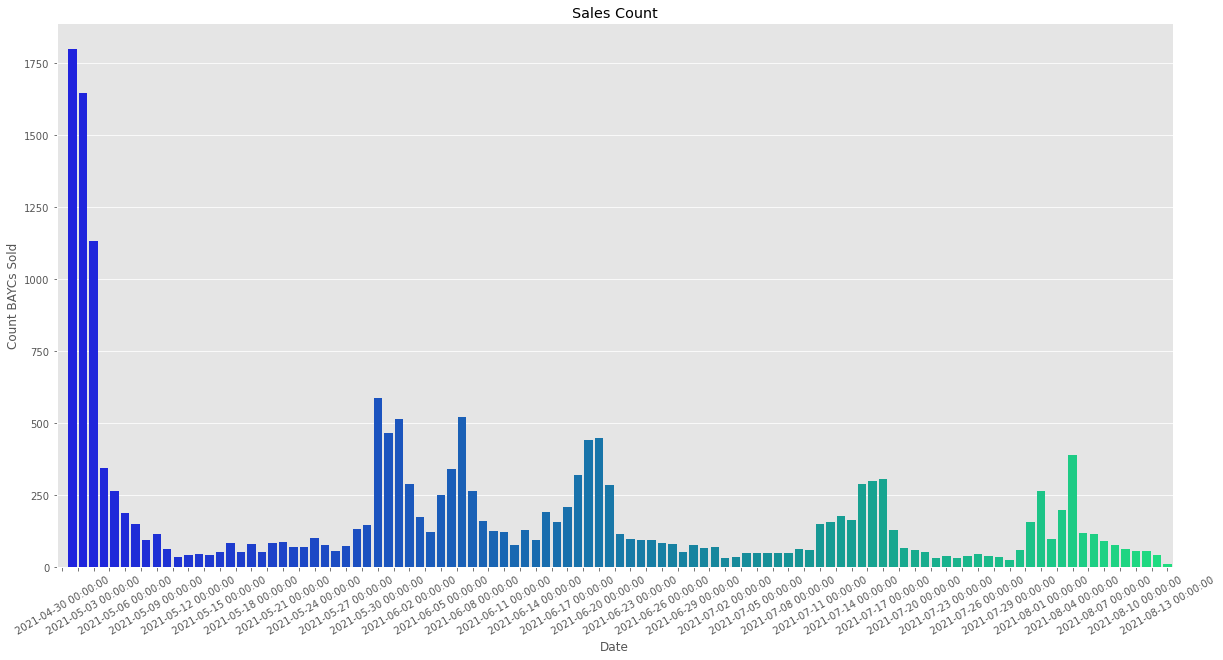

In [24]:
data = BAYCs_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').count()['total_price']
data = pd.DataFrame(data)
data.columns = ['Count BAYCs Sold']
#ax = data.plot.bar(figsize=(18, 5))

plt.figure(figsize=(20,10))
ax = sns.barplot(x=data.index, y=data['Count BAYCs Sold'], palette="winter")
plt.xlabel("Date")
plt.title("Sales Count")

ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);
ax.xaxis.set_major_locator(plt.MaxNLocator(100));

#### Total Sales per Day in ETH

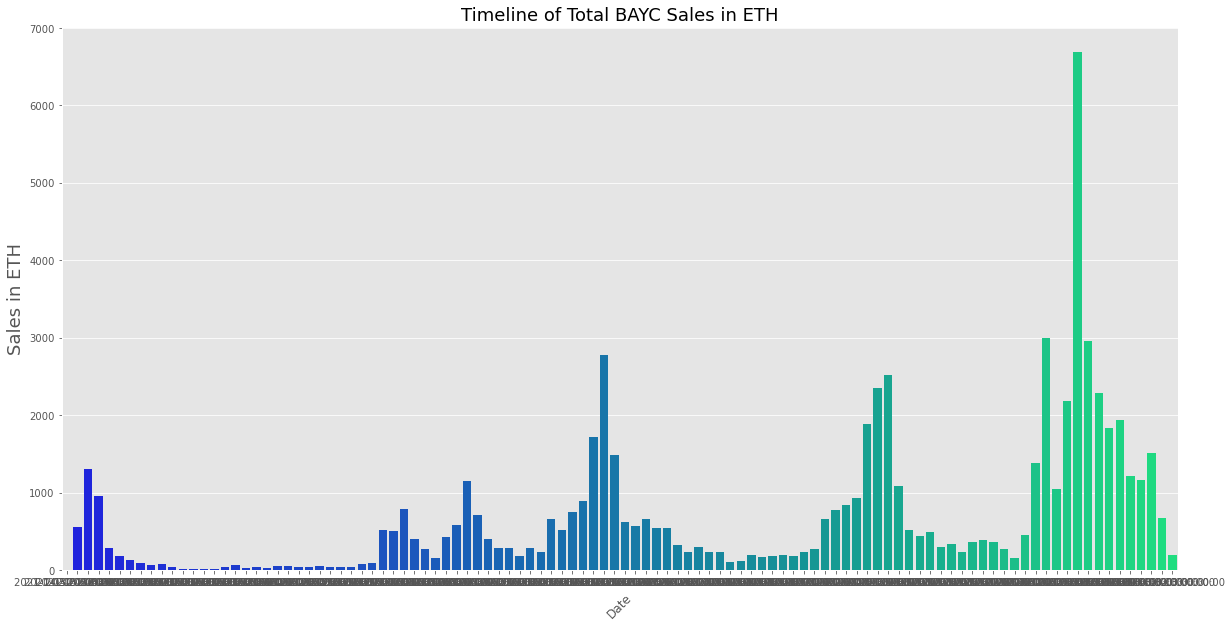

In [25]:
data = BAYCs_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').sum()['total_price']
data = pd.DataFrame(data)
data.columns = ['total_price']

plt.figure(figsize=(20,10))
ax=sns.barplot(x=data.index, y=data['total_price'], palette="winter")
plt.xlabel("Date", rotation=45)
plt.title("Sales Count")

ax.set_title("Timeline of Total BAYC Sales in ETH", fontsize=18)
ax.set_ylabel("Sales in ETH", fontsize=18);


#### Total Sales per day in USD

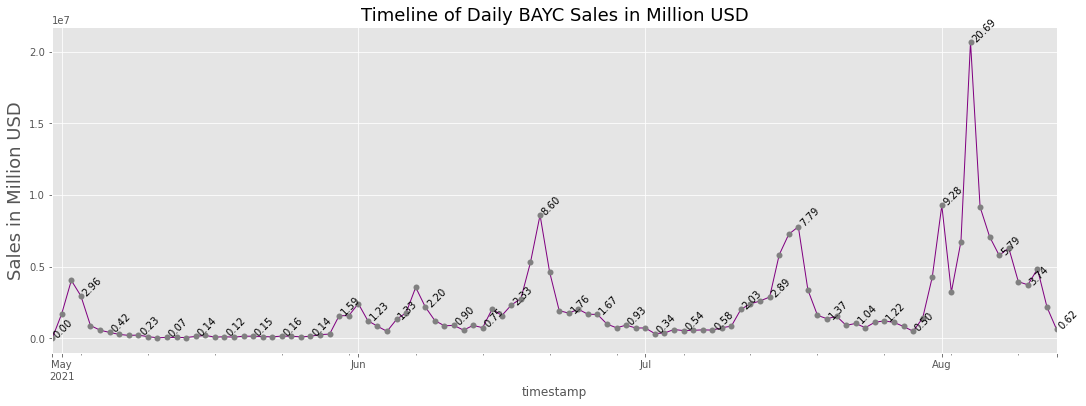

In [26]:
data = BAYCs_sales_df[['timestamp', 'total_price_usd']].resample('D', on='timestamp').sum()['total_price_usd']
ax = data.plot(figsize=(18,6), color="purple", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Daily BAYC Sales in Million USD", fontsize=18)
ax.set_ylabel("Sales in Million USD", fontsize=18);

dates = list(data.index)
values = list(data.values)

for idx,(i, j) in enumerate(zip(dates, values)):
    if idx % 3 == 0:
        ax.annotate(text="{:.2f}".format(j/10.**6), xy=(i, j), rotation=45)

### BAYCs Sales Prices Timelines 

#### Average BAYC Price per Day in ETH 

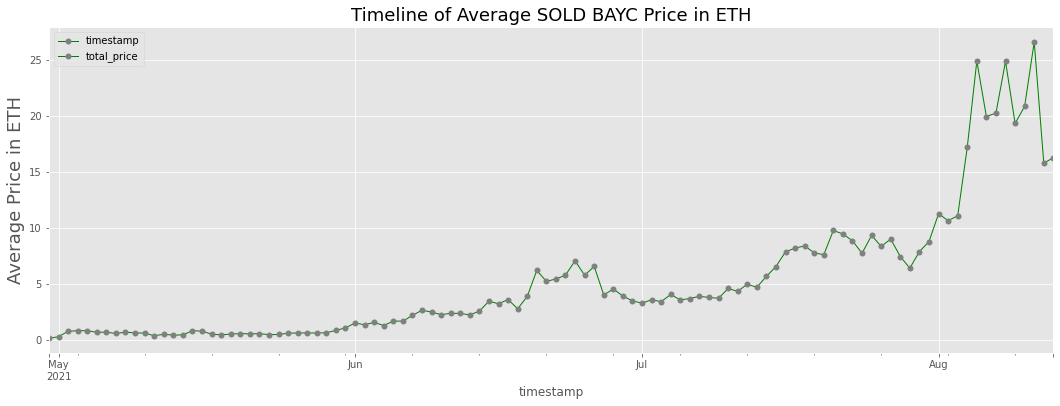

In [27]:
data = BAYCs_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').mean()['total_price']
data = pd.DataFrame(data,columns=['timestamp','total_price'])
#data['total_price'] = np.log(data['total_price'])
ax = data.plot(figsize=(18,6), color="green", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Average SOLD BAYC Price in ETH", fontsize=18)
ax.set_ylabel("Average Price in ETH", fontsize=18);
#ax.annotate(s='sdsdsds', xy=(1, 1))

dates = list(data.index)
values = list(data.values)

#### Floor BAYC Price per Day in ETH

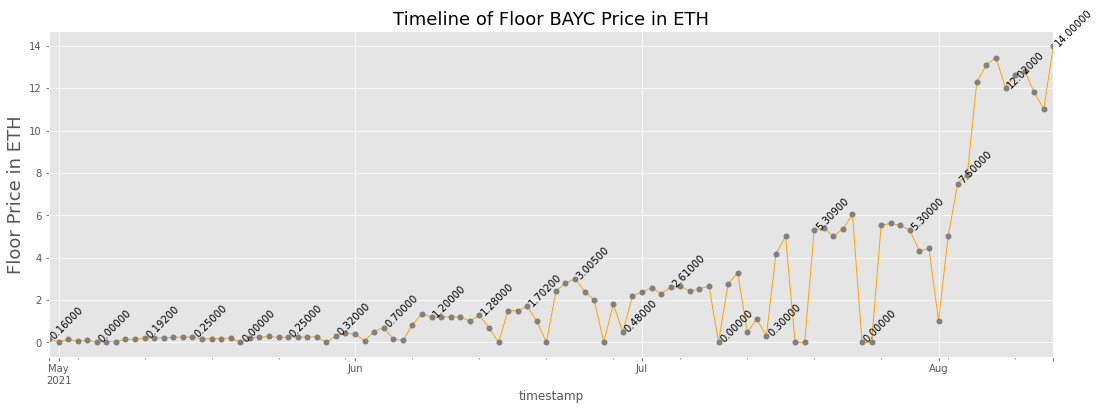

In [28]:
data = BAYCs_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').min()['total_price']
ax = data.plot(figsize=(18,6), color="orange", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Floor BAYC Price in ETH", fontsize=18)
ax.set_ylabel("Floor Price in ETH", fontsize=18);

dates = list(data.index)
values = list(data.values)

for idx,(d, v) in enumerate(zip(dates, values)):
    if idx%5 ==0:
        ax.annotate(text="{:.5f}".format(v), xy=(d, v), rotation=45);

#### Max BAYC Price per Day in ETH

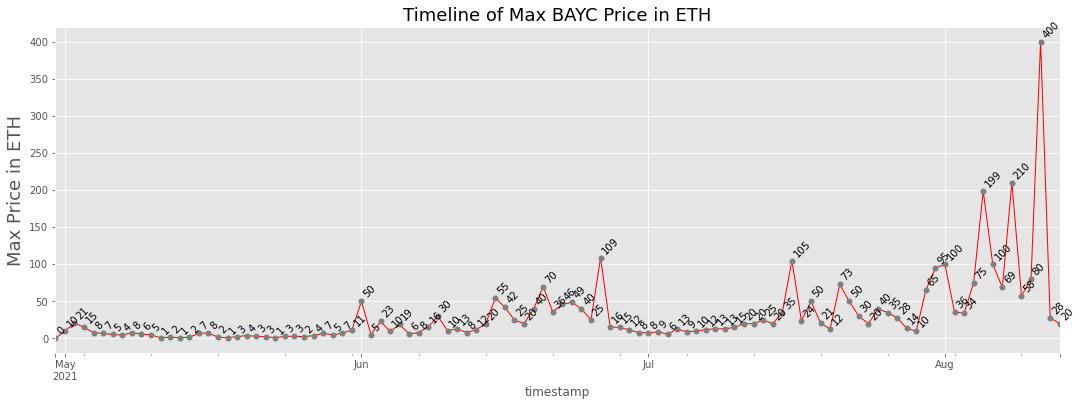

In [29]:
data = BAYCs_sales_df[['timestamp', 'total_price']].resample('D', on='timestamp').max()['total_price']
ax = data.plot(figsize=(18,6), color="red", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Max BAYC Price in ETH", fontsize=18)
ax.set_ylabel("Max Price in ETH", fontsize=18);

dates = list(data.index)
values = list(data.values)

for i, j in zip(dates, values):
    ax.annotate(text="{:.0f}".format(j), xy=(i, j+5), rotation=45);


# References

[0] [Data mining Meebits](http://adilmoujahid.com/posts/2021/06/data-mining-meebits-nfts-python-opensea/)

[1] [Fungibility - Wikipedia](https://en.wikipedia.org/wiki/Fungibility)

[2] [A Practical Introduction to NFTs using Solidity and Legos](http://adilmoujahid.com/posts/2021/05/intro-nfts-solidity/)

[3] [Counterparty - Wikipedia](https://bit.ly/3h6IfMU)

[4] [Counterparty - Bitcoinwiki](https://bit.ly/2T79teI)

[5] [Rare Pepe Gets Blockchained, Made Into Tradable Counterparty Tokens](https://news.bitcoin.com/rare-pepe-assets-get-blockchained/)